In [2]:
from tqdm import tqdm, trange
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import time
from datetime import timedelta

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

def print_update(epoch, iteration, loss, max_iters, start_time):
    t = time.perf_counter() - start_time
    dt = t / (iteration + 1)
    iters_left = max_iters - (iteration + 1)
    minutesr, secondsr = divmod(iters_left * dt, 60)
    minutess, secondss = divmod(t, 60)
    times = [int(minutesr), int(secondsr), int(minutess), int(secondss)]
    for i in range(4):
        if times[i] < 10:
            times[i] = f'0{times[i]}'
    print('Epoch ', epoch, ': Iteration ', iteration+1, '/', max_iters, ' | Loss: ', loss, '  |  Time remaining: ', times[0], ':', times[1], '  |  Time spent: ', times[2], ':', times[3], end = '\r', sep = '')

In [10]:
class DeepBase(nn.Module):
    
    def __init__(self):
        super(DeepBase, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        resnet = torchvision.models.resnet18(pretrained=True)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])
        
        self.upsample = nn.Sequential(
            nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size = 3, stride = 1, padding = 1),
            nn.Upsample(scale_factor = 2)
        )
        
    def forward(self, img):
        
        features = self.encoder(img)
        return self.upsample(features)

tensor(-0.1402) tensor(0.2496)
tensor(1.0767) tensor(1.0598)


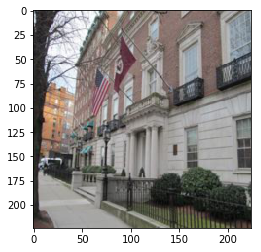

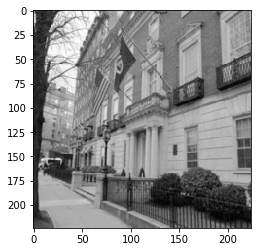

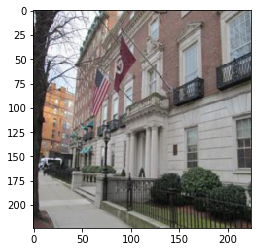

In [11]:
class GrayscaleImageFolder(ImageFolder):
    
    def __getitem__(self, idx):
        path, target = self.imgs[idx]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_ab = img_lab[:,:,1:3] / 128
            img_ab = torch.from_numpy(img_ab.transpose((2,0,1))).float()
            img_original_gray = rgb2gray(img_original)
            img_original_gray = torch.from_numpy((img_lab[:,:,0]-50)/50).unsqueeze(0).float()

        return img_original_gray, img_ab, img_original

def to_rgb(gray_input, ab_input, original):
    color_image = torch.cat((gray_input, ab_input), 0).numpy()
    color_image = color_image.transpose((1,2,0))
    color_image[:,:,0:1] = color_image[:,:,0:1] * 50 + 50
    color_image[:,:,1:3] = color_image[:,:,1:3] * 128
    color_image = lab2rgb(color_image.astype(np.float64))
    gray_input = gray_input.squeeze().numpy()
    plt.imshow(original)
    plt.show()
    plt.imshow(gray_input, cmap='gray')
    plt.show()
    plt.imshow(color_image)
    plt.show()
    
train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('data/Places/places365_standard/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=128, shuffle=True, num_workers = 6)
for i, (input_gray, input_ab, original) in enumerate(train_loader):
    print(torch.mean(input_gray), torch.mean(input_ab))
    print(torch.std(input_gray), torch.std(input_ab))
    to_rgb(input_gray[0], input_ab[0], original[0])
    break

In [12]:
model = DeepBase().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)

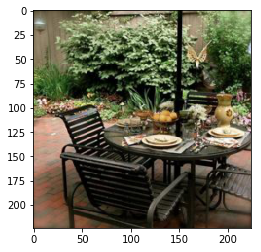

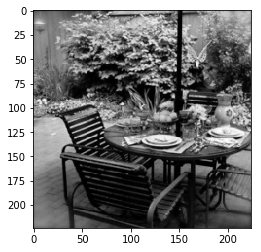

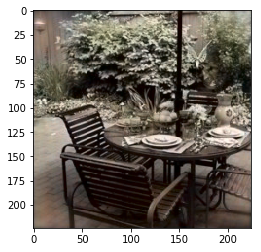

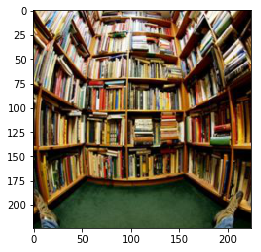

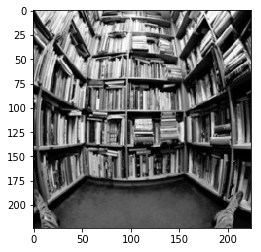

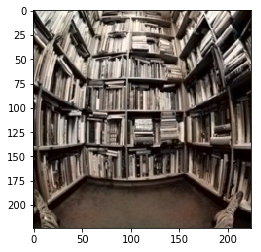

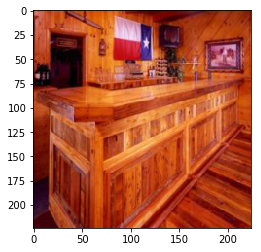

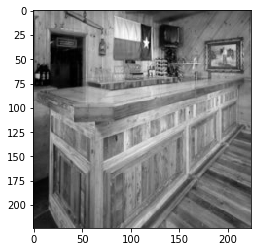

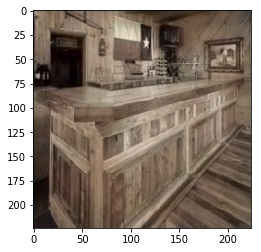

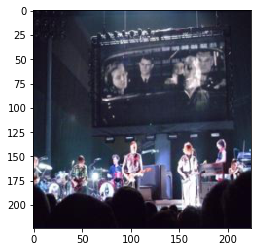

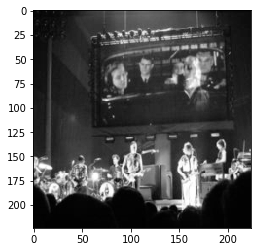

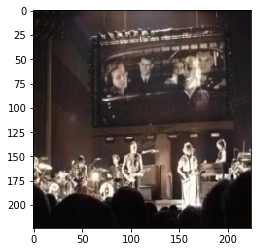

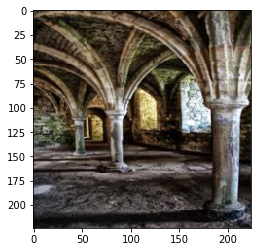

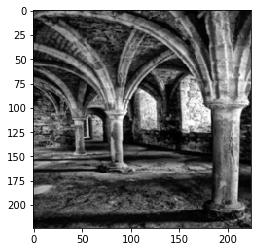

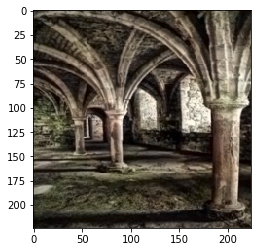

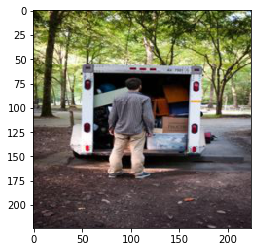

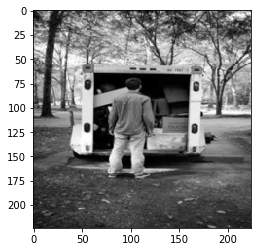

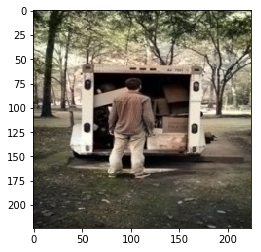

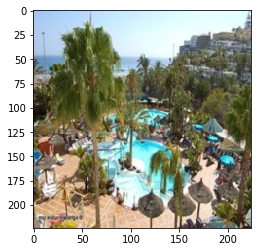

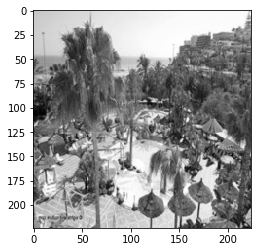

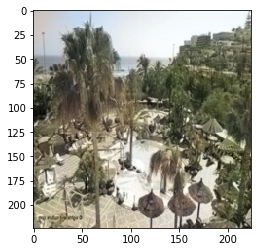

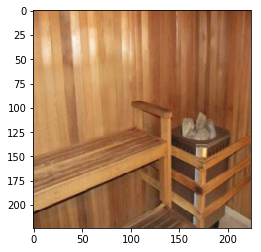

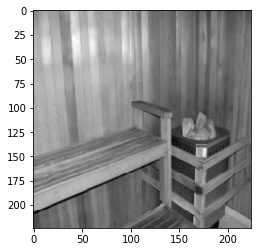

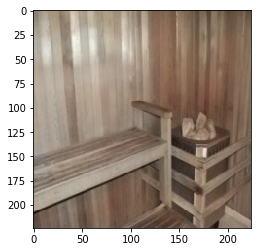

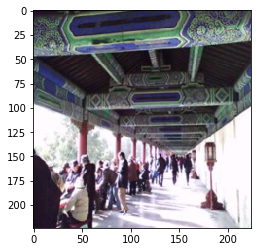

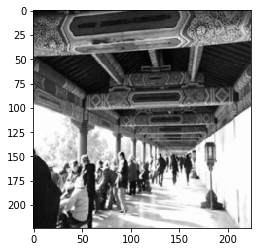

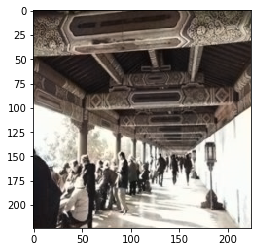

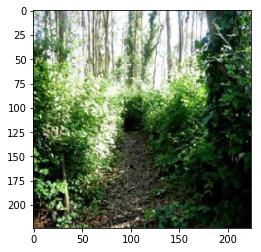

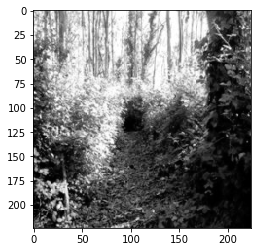

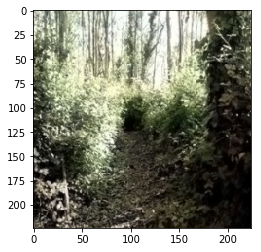

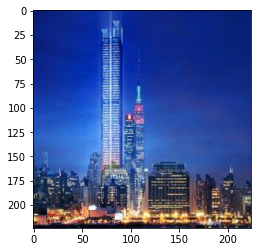

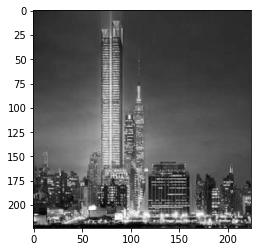

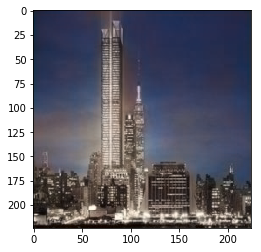

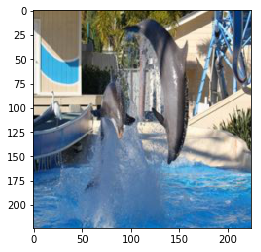

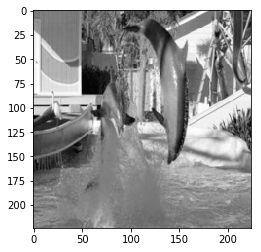

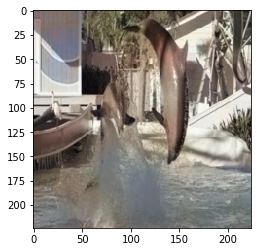

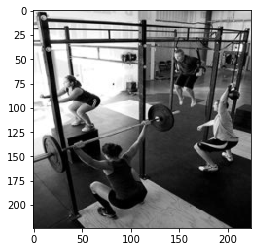

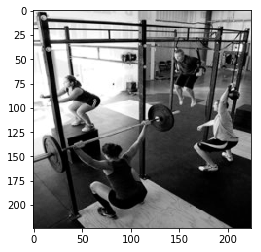

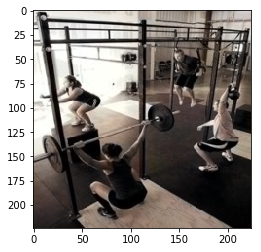

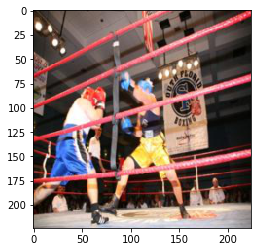

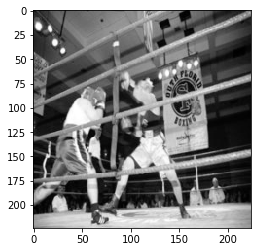

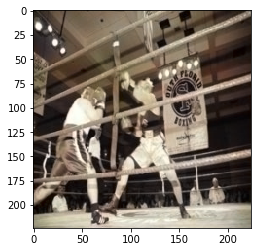

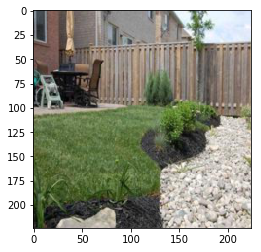

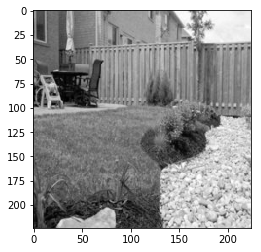

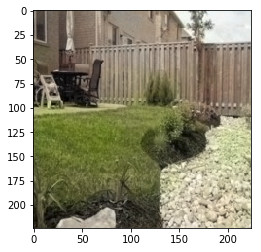

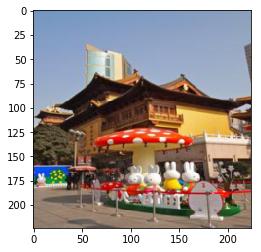

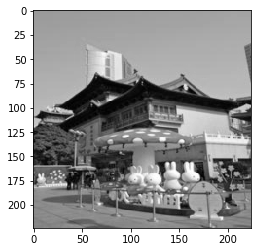

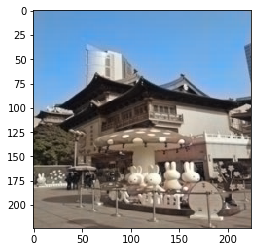

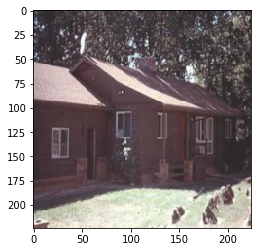

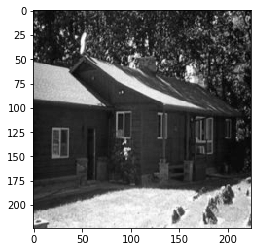

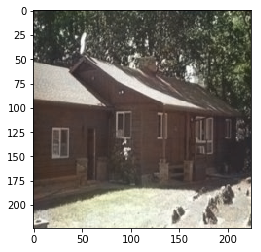

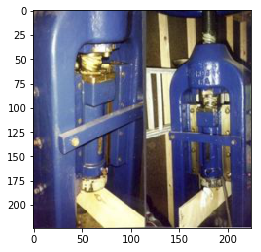

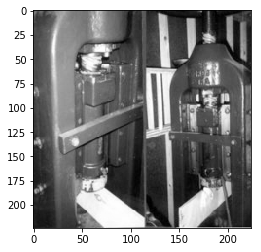

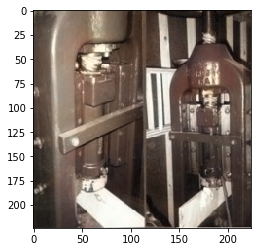

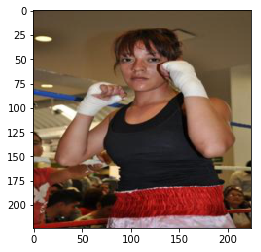

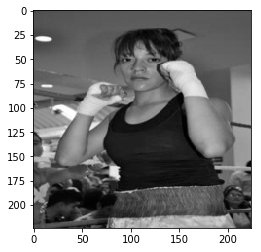

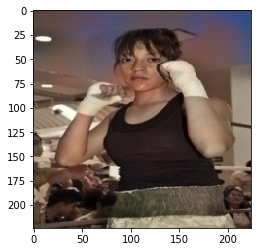

KeyboardInterrupt: 

In [13]:
def train(train_loader, model, criterion, optimizer, epoch = 0):
    model.train()

    start_time = time.perf_counter()
    losses = []
    for i, (input_gray, input_ab, original) in enumerate(train_loader):

        # Use GPU if available
        input_gray, input_ab = input_gray.cuda(), input_ab.cuda()
        
        # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.append(loss.item())

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i % 2) != (len(train_loader) % 2): print_update(epoch, i, loss.item(), len(train_loader), start_time)
        if i % 100 == 50: to_rgb(input_gray[0].detach().cpu(), output_ab[0].detach().cpu(), original[0])

    return losses

ls = []
for epoch in range(1):
    l = train(train_loader, model, criterion, optimizer, epoch)
    ls = ls + l

In [ ]:
plt.plot(ls)
plt.show()

In [ ]:
for i, (input_gray, input_ab, original) in enumerate(train_loader):

    input_gray, input_ab = input_gray.cuda(), input_ab.cuda()
    output_ab = model(input_gray) 
    to_rgb(input_gray[0].detach().cpu(), output_ab[0].detach().cpu(), original[0])
    break
#     if i == 5: break